## Computer vision 2022 Assignment 3: Deep Learning for Perception Tasks

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question requires you to write a short description of a Computer Vision method. You wil lneed to submit two separate files, one for each question.

# Question 1: A simple classifier, 20 marks (70%)

For this exercise, we provide demo code showing how to train a network on a small dataset called Fashion-MNIST. Please run through the code "tutorial-style" to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network.

For the Fashion-MNIST dataset the lables from 0-9 correspond to various clothing classes so you might find it convenient to create a python list as follows:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure. 

Organize your own text and code cell to show the answer of each questions.



## Question 1.1

Q1.1 (1 point)

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels. 

Please see the images displayed below.

In [2]:
import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [4]:
batch_size = 64
num_workers = 20

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Add in a code cell to inspect the training data, as per Q1.1. Each element of the training_data structure has a greyscale image (which you can use plt.imshow(img[0,:,:]) to display, just like you did in previous assignments.  

Size and shape of training images: torch.Size([1, 28, 28])


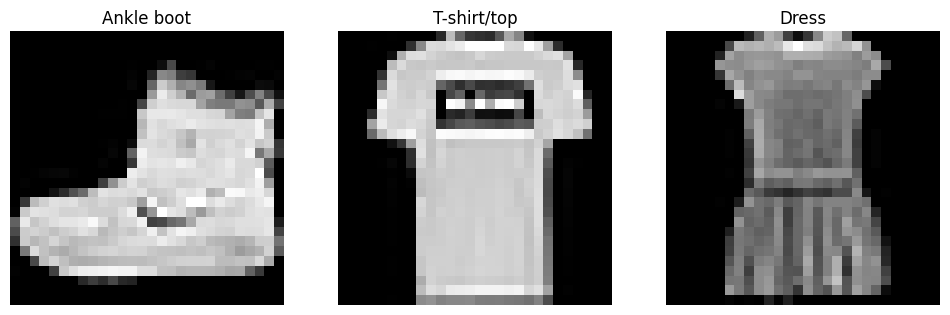

In [5]:
print(f"Size and shape of training images: {training_data[0][0].shape}")

# defining the function to draw the images
def plot_image(image, label, ax):
    image = image.numpy().squeeze()
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{training_data.classes[label]}')
    ax.axis('off')


images, labels = [], []
unique_labels = set()
for img, lbl in training_data:
    if lbl not in unique_labels:
        images.append(img)
        labels.append(lbl)
        unique_labels.add(lbl)
    if len(unique_labels) >= 3:
        break


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for img, lbl, ax in zip(images, labels, axes):
    plot_image(img, lbl, ax)
plt.show()

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
##Define a test function
def test(dataloader, model, loss_fn,):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
#Train and test the model
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305552  [    0/60000]
loss: 2.292030  [ 6400/60000]
loss: 2.283248  [12800/60000]
loss: 2.279021  [19200/60000]
loss: 2.248799  [25600/60000]
loss: 2.236767  [32000/60000]
loss: 2.239798  [38400/60000]
loss: 2.211297  [44800/60000]
loss: 2.212178  [51200/60000]
loss: 2.183519  [57600/60000]
Test Error: 
 Accuracy: 50.1%, Avg loss: 2.179195 

Epoch 2
-------------------------------
loss: 2.186590  [    0/60000]
loss: 2.176636  [ 6400/60000]
loss: 2.137857  [12800/60000]
loss: 2.151737  [19200/60000]
loss: 2.094538  [25600/60000]
loss: 2.055787  [32000/60000]
loss: 2.079300  [38400/60000]
loss: 2.015861  [44800/60000]
loss: 2.023423  [51200/60000]
loss: 1.960742  [57600/60000]
Test Error: 
 Accuracy: 59.5%, Avg loss: 1.959181 

Epoch 3
-------------------------------
loss: 1.983575  [    0/60000]
loss: 1.956841  [ 6400/60000]
loss: 1.868469  [12800/60000]
loss: 1.899364  [19200/60000]
loss: 1.784761  [25600/60000]
loss: 1.749277  [32000/600

## Question 1.2

Q1.2 (2 point) Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

|Lr|Accuracy|
|---|---|
|1    |20.0%|
|0.1  |87.7%|
|0.01 |83.4%|
|0.001|70.5%|

(Please see extended results bellow)

Through the following I'm going to be duplicating the code from the example and modifying it to get the results for this question.

In [39]:
# Question 1.2

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [40]:
## Define a trainging function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [41]:
##Define a test function
def test(dataloader, model, loss_fn,):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return correct*100, test_loss

In [42]:
# settings
learning_rates = [1, 0.1, 0.01, 0.001]
epochs = 10
results = {}

for learning_rate in learning_rates:
    model = NeuralNetwork().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    print(f"Learning Rate {learning_rate}")
    losses = []
    accuracies = []

    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)
        accuracy, loss = test(test_dataloader, model, loss_fn)
        accuracies.append(accuracy)
        losses.append(loss)
        print(f"Epoch {t+1}: accuracy - {accuracy:>0.1f}%")

    results[learning_rate] = {'accuracies': accuracies, 'losses': losses}

print("Done!")

Learning Rate 1
Epoch 1: accuracy - 20.0%
Epoch 2: accuracy - 20.6%
Epoch 3: accuracy - 10.0%
Epoch 4: accuracy - 24.3%
Epoch 5: accuracy - 19.9%
Epoch 6: accuracy - 20.5%
Epoch 7: accuracy - 10.1%
Epoch 8: accuracy - 20.2%
Epoch 9: accuracy - 20.2%
Epoch 10: accuracy - 20.0%
Learning Rate 0.1
Epoch 1: accuracy - 79.7%
Epoch 2: accuracy - 82.5%
Epoch 3: accuracy - 83.8%
Epoch 4: accuracy - 84.8%
Epoch 5: accuracy - 85.5%
Epoch 6: accuracy - 86.2%
Epoch 7: accuracy - 86.9%
Epoch 8: accuracy - 87.3%
Epoch 9: accuracy - 87.5%
Epoch 10: accuracy - 87.7%
Learning Rate 0.01
Epoch 1: accuracy - 71.0%
Epoch 2: accuracy - 77.8%
Epoch 3: accuracy - 79.8%
Epoch 4: accuracy - 80.8%
Epoch 5: accuracy - 81.2%
Epoch 6: accuracy - 81.8%
Epoch 7: accuracy - 82.3%
Epoch 8: accuracy - 82.7%
Epoch 9: accuracy - 83.0%
Epoch 10: accuracy - 83.4%
Learning Rate 0.001
Epoch 1: accuracy - 26.2%
Epoch 2: accuracy - 49.6%
Epoch 3: accuracy - 60.1%
Epoch 4: accuracy - 63.3%
Epoch 5: accuracy - 64.8%
Epoch 6: accur

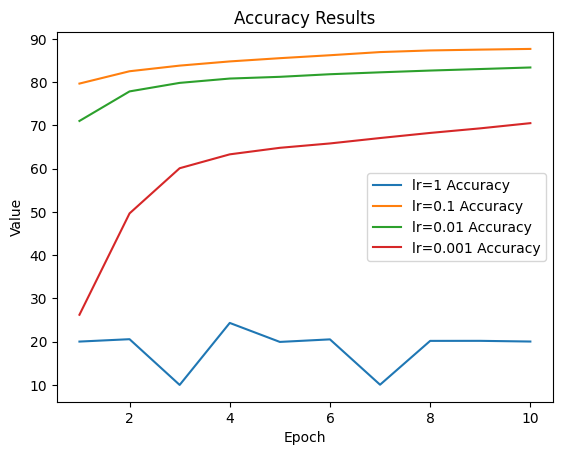

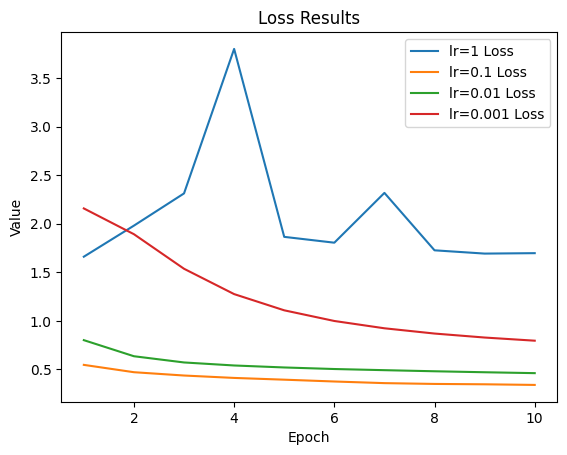

In [43]:
# Plotting the results Accuracy
for lr, metrics in results.items():
    plt.plot(range(1, epochs+1), metrics['accuracies'], label=f"lr={lr} Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy Results')
plt.legend()
plt.show()

# Plotting the results Loss
for lr, metrics in results.items():
    plt.plot(range(1, epochs+1), metrics['losses'], label=f"lr={lr} Loss")

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss Results')
plt.legend()
plt.show()

Looking at the results of this, we are able to see that it is most likely that Learning rate equal to 0.1 would be the best for this model. As that is going to balance both speed and the accuracy.

## Question 1.3

Q1.3 (3 point) Report the number of epochs when the network converges (or nukber of epochs for the best accuracy, if it fails to converge). Fill in the table below and plot the loss curve for each experiment:

|Lr|Accuracy|Epoch|
|---|---|---|
|1     |10.0%|1  |
|0.1   |88.0%|17 |
|0.01  |87.8%|50+|
|0.001 |82.7%|50+|

(Please see extended results bellow)

Through the following I'm going to be duplicating the code from the example and modifying it to get the results for this question.

In [44]:
# Question 1.3

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [45]:
## Define a trainging function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    average_loss = total_loss / len(dataloader)
    return average_loss

In [46]:
##Define a test function
def test(dataloader, model, loss_fn,):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return correct*100, test_loss

In [47]:
# settings
learning_rates = [1, 0.1, 0.01, 0.001]
epochs = 50
patience = 3
results = {}

for learning_rate in learning_rates:
    model = NeuralNetwork().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    print(f"Learning Rate {learning_rate}")
    losses = []
    accuracies = []
    best_loss = float('inf')
    epochs_no_improve = 0
    converged_epoch = None

    for t in range(epochs):
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        accuracy, loss = test(test_dataloader, model, loss_fn)
        accuracies.append(accuracy)
        losses.append(loss)
        print(f"Epoch {t+1}: accuracy - {accuracy:>0.1f}%, loss - {loss:>8f}")
        
        if loss < best_loss:
            best_loss = loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            converged_epoch = t + 1 - patience
            break

    if converged_epoch is None:
        converged_epoch = epochs

    results[learning_rate] = {'accuracies': accuracies, 'losses': losses, 'converged_epoch': converged_epoch}

print("Done!")

Learning Rate 1
Epoch 1: accuracy - 10.0%, loss - 2.304739
Epoch 2: accuracy - 10.0%, loss - 2.306479
Epoch 3: accuracy - 10.0%, loss - 2.305841
Epoch 4: accuracy - 10.0%, loss - 2.305844
Learning Rate 0.1
Epoch 1: accuracy - 78.5%, loss - 0.550608
Epoch 2: accuracy - 81.6%, loss - 0.478730
Epoch 3: accuracy - 83.6%, loss - 0.434355
Epoch 4: accuracy - 84.5%, loss - 0.413341
Epoch 5: accuracy - 85.8%, loss - 0.384923
Epoch 6: accuracy - 86.5%, loss - 0.370060
Epoch 7: accuracy - 86.6%, loss - 0.366587
Epoch 8: accuracy - 87.1%, loss - 0.358751
Epoch 9: accuracy - 87.3%, loss - 0.349779
Epoch 10: accuracy - 87.6%, loss - 0.347901
Epoch 11: accuracy - 87.6%, loss - 0.347509
Epoch 12: accuracy - 87.6%, loss - 0.347526
Epoch 13: accuracy - 87.7%, loss - 0.348295
Epoch 14: accuracy - 87.8%, loss - 0.346894
Epoch 15: accuracy - 87.9%, loss - 0.347529
Epoch 16: accuracy - 88.0%, loss - 0.349170
Epoch 17: accuracy - 88.0%, loss - 0.343744
Epoch 18: accuracy - 88.0%, loss - 0.349200
Epoch 19: a

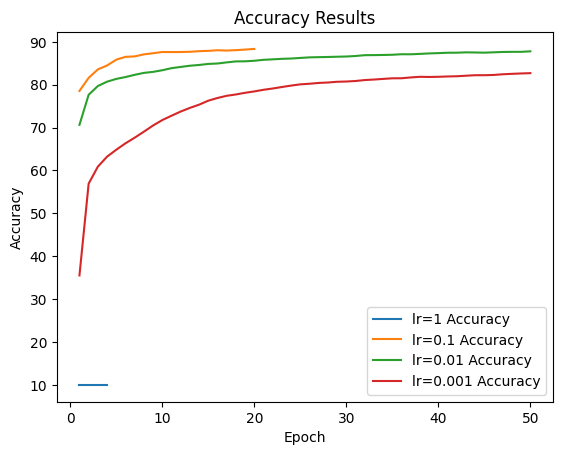

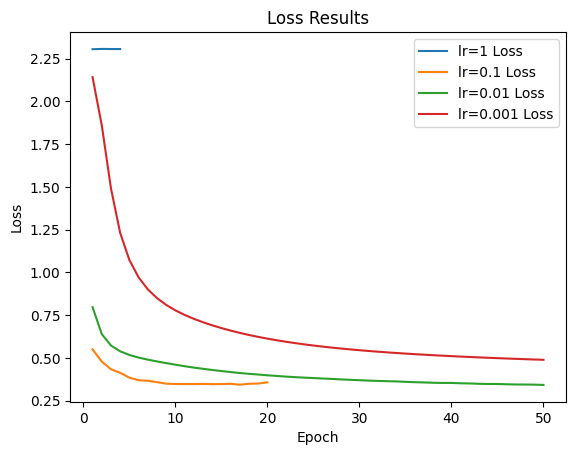

Learning Rate 1 converged at epoch 1
Learning Rate 0.1 converged at epoch 17
Learning Rate 0.01 converged at epoch 50
Learning Rate 0.001 converged at epoch 50


In [48]:
for lr, metrics in results.items():
    plt.plot(range(1, len(metrics['accuracies']) + 1), metrics['accuracies'], label=f"lr={lr} Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Results')
plt.legend()
plt.show()

for lr, metrics in results.items():
    plt.plot(range(1, len(metrics['losses']) + 1), metrics['losses'], label=f"lr={lr} Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Results')
plt.legend()
plt.show()

for lr, metrics in results.items():
    print(f"Learning Rate {lr} converged at epoch {metrics['converged_epoch']}")


## Question  1.4

Q1.4 (2 points) Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?

First comparing the results in the table for each of the learning rates.

Learning rate 1: This high learning rate results in poor performace and convergence. Table 1 after 10 epochs the accuracy is 20% while table 2 after 1 epochs the accuracy is 10%. With a learning rate of 1 the network is struggling to learn effiecently which could likely be due to overshooting the optimal soltion.

Learning rate 0.1: With this learning rate the network achieves a high accuracy relatively quickly. Table 1 shows 87.7% after 10 epochs and table 2 shows 88.0% after 17 epochs. This learning rate converges fast with a high accuracy and is the optimal learning rate for this network.

Learning rate 0.01: With this learning rate the network converges slower. Table 1 shows 87.8% accuracy after 10 epochs and table 2 shows 87.8% after 50 epochs. Showing that the network is taking longer to converge. This learning rate is requiring more epochs to reach simlar accuracy to the network with learning rate 0.1

Learning rate 0.001: This learning rate is very slow to converge. After running 100 epochs the network was unable to converge. Table 1 after 10 epochs produced and accuracy of 70.5% and table 2 shows an accuracy of 82.7% after 50 epochs. This is showing that the network is able to produce a good result but needs to time to train to reach a similar place to the other networks.

The higher learning rate leads to the rapid changes and causes fluctuations between the epochs producing a result that is unfavourable and not the optimal solution that is most likely that it has overshow the optimal solution. The moderate learning rate resulted in the best for this model, as it provides relatively fast learning and converges to result in a good solution. The low learning rate resulting in the slowest learning, but after a while it would results is a relativly accuracte solution but will need more time to converge.

## Question 1.5

Q1.5 (5 points) Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

|Structures|Accuracy|Parameters|
|---|---|---|
|Base  |87.1%| 669706|
|Deeper|86.7%|1195018|
|Wider |87.8%|1863690|

(Please see extended results bellow)

More of the models

In [26]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

Using cpu device


In [27]:
# Define the orginal model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

originalModel = NeuralNetwork().to(device)
print(model)

deepNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [28]:
# Define the wide model
class wideNeuralNetwork(nn.Module):
    def __init__(self):
        super(wideNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

wideModel = wideNeuralNetwork().to(device)
print(wideModel)

wideNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [29]:
# Define the deep model
class deepNeuralNetwork(nn.Module):
    def __init__(self):
        super(deepNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

deepModel = deepNeuralNetwork().to(device)
print(deepModel)

deepNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [30]:
model_params = sum(p.numel() for p in originalModel.parameters())
print(f"Original Model Parameter: {model_params}")
wider_model_params = sum(p.numel() for p in wideModel.parameters())
print(f"Wide Model Parameter: {wider_model_params}")
deep_model_params = sum(p.numel() for p in deepModel.parameters())
print(f"Deep Model Parameter: {deep_model_params}")

Original Model Parameter: 669706
Wide Model Parameter: 1863690
Deep Model Parameter: 1195018


In [31]:
## Define a trainging function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    average_loss = total_loss / len(dataloader)
    return average_loss

In [32]:
##Define a test function
def test(dataloader, model, loss_fn,):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return correct*100, test_loss

In [33]:
# settings
epochs = 10

In [34]:
print("Results for the original Network")

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

validation_losses_original = []
validation_accuracy_original = []

for t in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    accuracy, loss = test(test_dataloader, model, loss_fn)
    validation_losses_original.append(loss)
    validation_accuracy_original.append(accuracy)
    print(f"Epoch {t+1}: accuracy - {accuracy:>0.1f}%")


Results for the original Network
Epoch 1: accuracy - 79.3%
Epoch 2: accuracy - 82.1%
Epoch 3: accuracy - 84.3%
Epoch 4: accuracy - 85.5%
Epoch 5: accuracy - 86.6%
Epoch 6: accuracy - 86.9%
Epoch 7: accuracy - 87.2%
Epoch 8: accuracy - 87.3%
Epoch 9: accuracy - 87.6%
Epoch 10: accuracy - 87.2%


In [35]:
print("Results for the wide Network")

model = wideNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

validation_losses_wide = []
validation_accuracy_wide = []

for t in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    accuracy, loss = test(test_dataloader, model, loss_fn)
    validation_losses_wide.append(loss)
    validation_accuracy_wide.append(accuracy)
    print(f"Epoch {t+1}: accuracy - {accuracy:>0.1f}%")


Results for the wide Network
Epoch 1: accuracy - 79.5%
Epoch 2: accuracy - 82.5%
Epoch 3: accuracy - 84.0%
Epoch 4: accuracy - 85.3%
Epoch 5: accuracy - 85.7%
Epoch 6: accuracy - 86.3%
Epoch 7: accuracy - 86.5%
Epoch 8: accuracy - 87.2%
Epoch 9: accuracy - 87.1%
Epoch 10: accuracy - 87.5%


In [36]:
print("Results for the deep Network")

model = deepNeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

validation_losses_deep = []
validation_accuracy_deep = []

for t in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    accuracy, loss = test(test_dataloader, model, loss_fn)
    validation_losses_deep.append(loss)
    validation_accuracy_deep.append(accuracy)
    print(f"Epoch {t+1}: accuracy - {accuracy:>0.1f}%")

Results for the deep Network
Epoch 1: accuracy - 78.8%
Epoch 2: accuracy - 80.6%
Epoch 3: accuracy - 82.2%
Epoch 4: accuracy - 83.8%
Epoch 5: accuracy - 84.2%
Epoch 6: accuracy - 85.3%
Epoch 7: accuracy - 85.2%
Epoch 8: accuracy - 85.4%
Epoch 9: accuracy - 86.1%
Epoch 10: accuracy - 86.6%


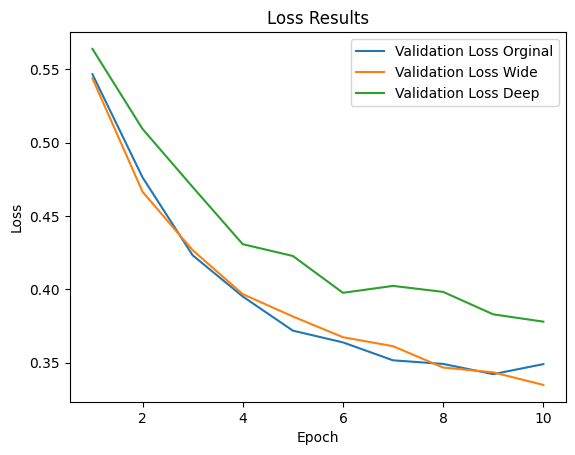

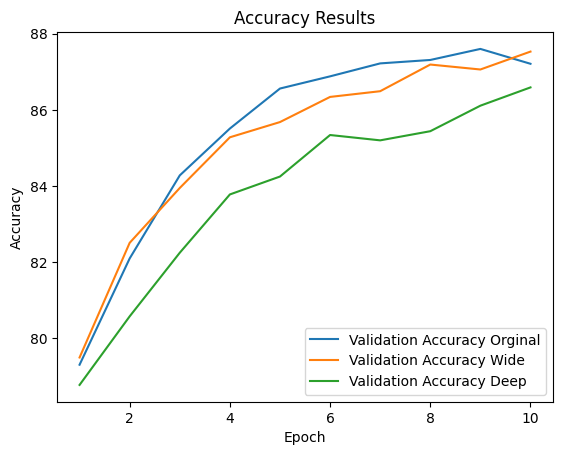

In [38]:
plt.plot(range(1, epochs + 1), validation_losses_original, label=f"Validation Loss Orginal")
plt.plot(range(1, epochs + 1), validation_losses_wide, label=f"Validation Loss Wide")
plt.plot(range(1, epochs + 1), validation_losses_deep, label=f"Validation Loss Deep")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Results')
plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), validation_accuracy_original, label=f"Validation Accuracy Orginal")
plt.plot(range(1, epochs + 1), validation_accuracy_wide, label=f"Validation Accuracy Wide")
plt.plot(range(1, epochs + 1), validation_accuracy_deep, label=f"Validation Accuracy Deep")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Results')
plt.legend()
plt.show()

Looking at the overall results from the 3 different models, the wider model looks to be achieving the best results out of the three different models with the best accuracy and the loss decreacing the most. The worst one overall was the deep one producing the worst result.

## Question 1.6

Q1.6 (2 points) Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

From the last question all the needs to be changes is the training function. So the orignal model will be called using the same functions with a modifyed trainging function.

In [161]:
## Define a trainging function
def train(dataloader, model, loss_fn, optimizer, moving_average_window=5):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    mean_gradients = []
    moving_average_gradients = []
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        total_gradients = 0
        for parameter in model.parameters():
            if parameter.grad is not None:
                total_gradients += parameter.grad.mean().item()
        mean_gradients.append(total_gradients / len(list(model.parameters())))

        if len(mean_gradients) >= moving_average_window:
            moving_average = sum(mean_gradients[-moving_average_window:]) / moving_average_window
            moving_average_gradients.append(moving_average)
        else:
            moving_average_gradients.append(sum(mean_gradients) / len(mean_gradients))

        if batch >= 99:
            break

    average_loss = total_loss / len(dataloader)
    return mean_gradients, moving_average_gradients

Done!


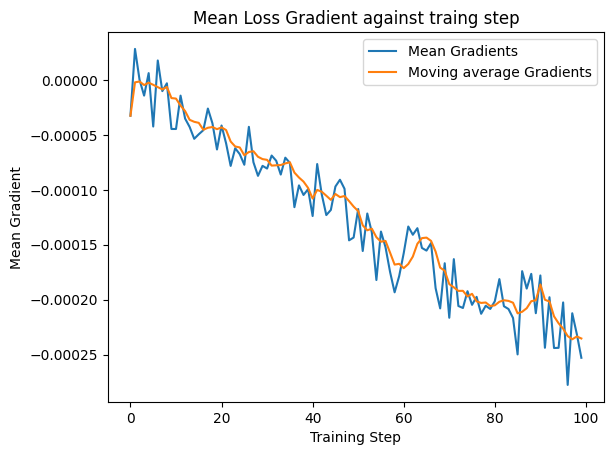

In [171]:
# Initialize the model, loss function, and optimizer
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

mean_gradients, moving_average_gradients = train(train_dataloader, model, loss_fn, optimizer)

print("Done!")

# Plotting the mean gradients for the first 100 training steps
plt.plot(mean_gradients[:100], label="Mean Gradients")
plt.plot(moving_average_gradients[:100], label="Moving average Gradients")
plt.xlabel('Training Step')
plt.ylabel('Mean Gradient')
plt.title('Mean Loss Gradient against traing step')
plt.legend()
plt.show()

The observations of this graph is that it is trending down, which is what we want to see. This is telling us that the model is moving toward more optimal values which means that our model is becomming more accurate. As we also have a faiarly consitant gratient we are able to duduce that we have picked a good learning rate for this model.

## Question 1.7

For more exlanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

Q1.7 (5 points) Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with rehgard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)
print(model)

number_of_parameters = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters {number_of_parameters}")

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Total number of parameters 421738


In [24]:
## Define a trainging function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    average_loss = total_loss / len(dataloader)
    return average_loss

In [25]:
##Define a test function
def test(dataloader, model, loss_fn,):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct

In [26]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

validation_accuracies = []

epochs = 13
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validation_accuracy = test(test_dataloader, model, loss_fn)
    validation_accuracies.append(validation_accuracy)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.462106 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.382938 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.362718 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.333973 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.308157 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 90.8%, Avg loss: 0.275749 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 91.0%, Avg loss: 0.274980 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 90.9%, Avg loss: 0.300184 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 91.4%, Avg loss: 0.291450 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 90.9%, Avg loss: 0.316099 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 90.8%, Avg los

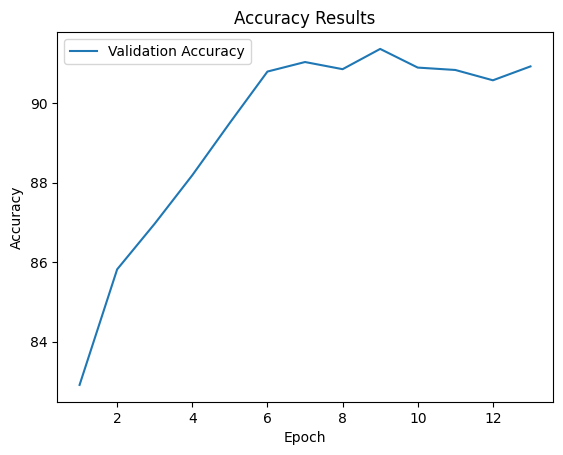

In [27]:
plt.plot(range(1, epochs + 1), validation_accuracies, label=f"Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Results')
plt.legend()
plt.show()


Looking at this convolutional neural network it can be wee that it is performing better then the MLP in all the following areas, convergence, accuracy, and the numher of parameters. This model above has a total of 421834 which is over 200000 parameters less than the original MLP network. In regards to the convergence it is also doing better then the MLP by converging after 12 epochs which is better then the MLP by 2 for the model that acheived the best accuracy. It also beat the best MLP model in accuracy also by achiving 91.0% which is better then the best MLP model by 3%. Overall this model is working better then the MLP model, and with some more optimizations it could be achiving a better accuracy. This optimisations could include adding more layers to the model, Decreasing the learing rate overtime, as the model is converging, and also some data augmentation to the model more generic. These optimisation could more the more accurate and produce a better result.
